# Poem Classification (NLP)

## Topic And Goal

The task is to classify poems into one of four genres: Affection, Environment, Music, and Death using an NLP method. This involves understanding and processing the text of poems to identify patterns and features that distinguish each genre.

I will use RNN models like LSTM and BiLSTM to do this NLP classification task.

[Github repo](https://github.com/BaffinLee/Poem-Classification-NLP)

## Dataset

This dataset is from [kaggle](https://www.kaggle.com/datasets/ramjasmaurya/poem-classification-nlp/data).

- train.csv: Contains labeled training data with columns 'Genre' and 'Poem'.
- test.csv: Contains labeled test data with columns 'Genre' and 'Poem'.

There are four genres of poems in this project: Affection, Environment, Music, and Death.

The train data contains 786 labeled poems, test data contains 150 labeled poems.


## Exploratory Data Analysis (EDA)

### Data Inspection

We start by loading and inspecting the data to understand its structure.

In [16]:
import pandas as pd

base_path = '/kaggle/input/poem-classification-nlp'

train_df = pd.read_csv(f'{base_path}/Poem_classification - train_data.csv')
test_df = pd.read_csv(f'{base_path}/Poem_classification - test_data.csv')

train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 841 entries, 0 to 840
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   841 non-null    object
 1   Poem    837 non-null    object
dtypes: object(2)
memory usage: 13.3+ KB


,Genre,Poem
0,Music,NaN
1,Music,In the thick brushthey spend the...
2,Music,Storms are generous. ...
3,Music,—After Ana Mendieta Did you carry around the ...
4,Music,for Aja Sherrard at 20The portent may itself ...


In [17]:
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   150 non-null    object
 1   Poem    150 non-null    object
dtypes: object(2)
memory usage: 2.5+ KB


,Genre,Poem
0,Music,A woman walks by the bench I’m sitting onwith ...
1,Music,"Because I am a boy, the untouchability of beau..."
2,Music,"Because today we did not leave this world,We n..."
3,Music,"Big Bend has been here, been here. Shouldn’t i..."
4,Music,"I put shells there, along the lip of the road...."


## Data Cleaning

As you can see in the above inspection, there are empty data points in train data, let's remove it.

In [18]:
train_df = train_df.dropna(ignore_index=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   837 non-null    object
 1   Poem    837 non-null    object
dtypes: object(2)
memory usage: 13.2+ KB


Then we clean the text data by removing punctuation, converting to lowercase, and tokenizing the text.

In [19]:
import re
import string

# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.strip()  # Remove whitespace
    return text

train_df['Poem_Cleaned'] = train_df['Poem'].apply(clean_text)
test_df['Poem_Cleaned'] = test_df['Poem'].apply(clean_text)

train_df.head()
test_df.head()

,Genre,Poem,Poem_Cleaned
0,Music,A woman walks by the bench I’m sitting onwith ...,a woman walks by the bench i’m sitting onwith ...
1,Music,"Because I am a boy, the untouchability of beau...",because i am a boy the untouchability of beaut...
2,Music,"Because today we did not leave this world,We n...",because today we did not leave this worldwe no...
3,Music,"Big Bend has been here, been here. Shouldn’t i...",big bend has been here been here shouldn’t it ...
4,Music,"I put shells there, along the lip of the road....",i put shells there along the lip of the roadbi...


In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['Poem_Cleaned'])

max_length = 100  # Maximum length of sequences
train_sequences = tokenizer.texts_to_sequences(train_df['Poem_Cleaned'])
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post')

test_sequences = tokenizer.texts_to_sequences(test_df['Poem_Cleaned'])
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post')

### Data transform

Let's transform the lables into numbers.

In [21]:
genre_to_index = {'Affection': 0, 'Environment': 1, 'Music': 2, 'Death': 3}
train_df['Genre_Type'] = train_df['Genre'].map(genre_to_index)
test_df['Genre_Type'] = test_df['Genre'].map(genre_to_index)
train_df.head()

,Genre,Poem,Poem_Cleaned,Genre_Type
0,Music,In the thick brushthey spend the...,in the thick brushthey spend the hottest part ...,2
1,Music,Storms are generous. ...,storms are generous ...,2
2,Music,—After Ana Mendieta Did you carry around the ...,—after ana mendieta did you carry around the m...,2
3,Music,for Aja Sherrard at 20The portent may itself ...,for aja sherrard at the portent may itself be ...,2
4,Music,"for Bob Marley, Bavaria, November 1980 Here i...",for bob marley bavaria november here is the b...,2


## Data Visualization

We visualize the distribution of genres in the training set and the distribution of poem lengths.

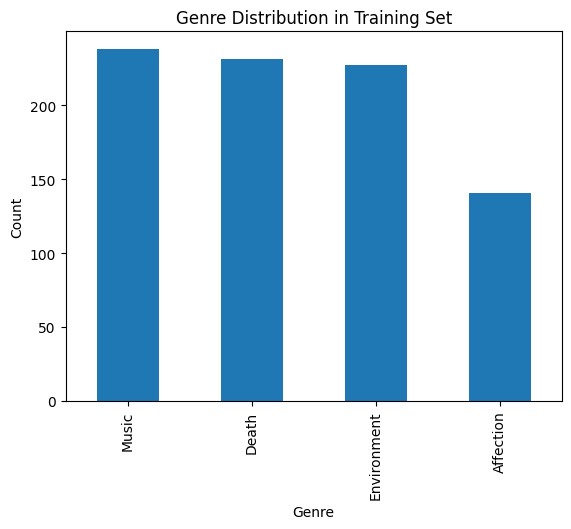

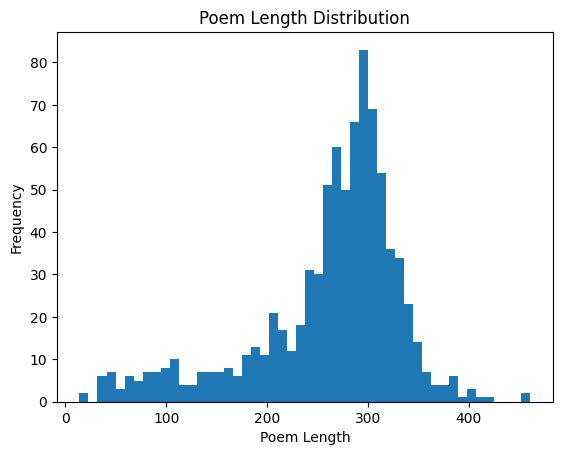

In [22]:
import matplotlib.pyplot as plt

# Distribution of genres in the training set
train_df['Genre'].value_counts().plot(kind='bar', title='Genre Distribution in Training Set')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.show()

# Histogram of poem lengths
train_df['Poem_length'] = train_df['Poem_Cleaned'].apply(lambda x: len(x))
train_df['Poem_length'].plot(kind='hist', bins=50, title='Poem Length Distribution')
plt.xlabel('Poem Length')
plt.ylabel('Frequency')
plt.show()

We visualize the most common words for each genre.

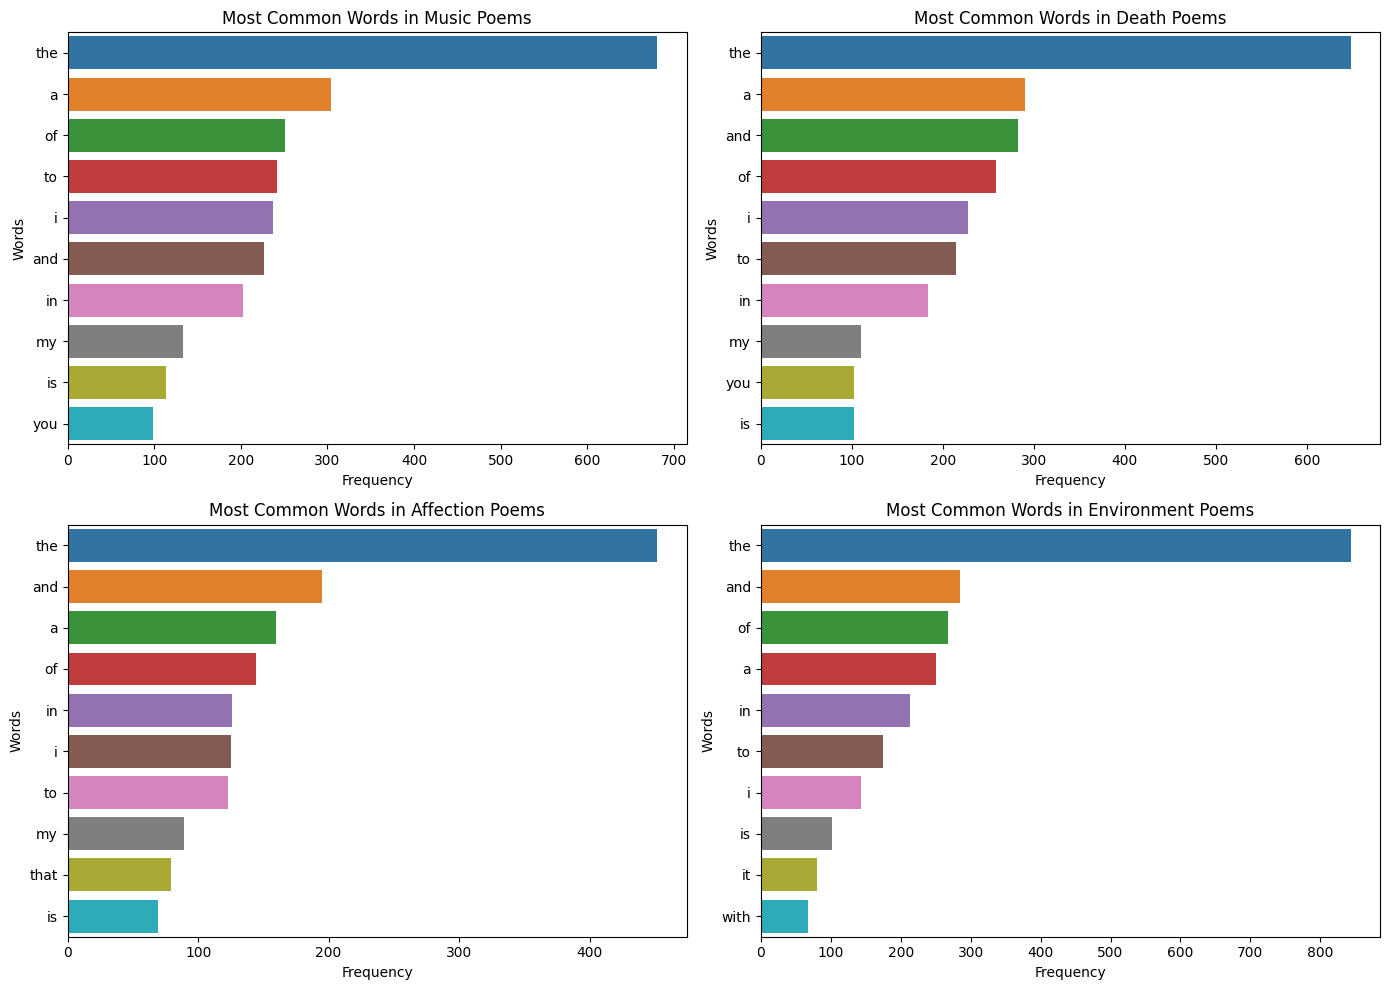

In [23]:
from collections import Counter
import seaborn as sns
import numpy as np

def plot_word_frequency_by_genre(df, genre, ax, top_n=10):
    genre_df = df[df['Genre'] == genre]
    all_words = ' '.join(genre_df['Poem_Cleaned']).split()
    word_counts = Counter(all_words)
    common_words = word_counts.most_common(top_n)
    
    words, counts = zip(*common_words)
    sns.barplot({
        'Words': np.array(words),
        'Frequency': np.array(counts)
    }, x='Frequency', y='Words', ax=ax)
    ax.set_title(f'Most Common Words in {genre} Poems')
    ax.set_ylabel('Words')
    ax.set_xlabel('Frequency')

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

genres = train_df['Genre'].unique()
for genre, ax in zip(genres, axes):
    plot_word_frequency_by_genre(train_df, genre, ax)

# Adjust layout
plt.tight_layout()
plt.show()

### Plan of Analysis

Based on the EDA, our plan of analysis is as follows:

- Preprocess the text data.
- Vectorize the text data using embeddings.
- Build and train different RNN models (LSTM, GRU) for classification.
- Tune hyperparameters and evaluate performance.

## Model

### Tokenization and Embedding

Tokenize the text data and convert it into numerical format. We will use Tokenizer module from keras library here. In the internal of that module, it will analyze and use the word frequency to convert text to sequence of numbers, so that we can train a model on it.

In [24]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['Poem_Cleaned'])
X_train = tokenizer.texts_to_sequences(train_df['Poem_Cleaned'])
X_test = tokenizer.texts_to_sequences(test_df['Poem_Cleaned'])

input_dim = len(tokenizer.word_index) + 1
max_length = max(len(x) for x in X_train)
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

y_train = np.array(train_df['Genre_Type'])
y_test = np.array(test_df['Genre_Type'])

# split dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(669, 69)
(669,)
(168, 69)
(168,)
(150, 69)
(150,)


### Model Architecture

We use an RNN model with LSTM layers for text classification because LSTM can capture long-term dependencies and context in text data.

We will also try Bidirectional LSTM layers because it often provides better performance due to its ability to leverage the full context of the sequence.

**LSTM Model Architecture**:

- Embedding Layer: Converts text input into dense vectors of fixed size.
- Spatial Dropout Layer: Adds spatial dropout to the embeddings to regularize and prevent overfitting.
- LSTM Layer: Captures sequential dependencies in the text.
- Dense Layer: Outputs the classification result.

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

def build_lstm_model(dropout=0.2, units=100, output_dim=128):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length))
    model.add(SpatialDropout1D(dropout))
    model.add(LSTM(units, dropout=dropout, recurrent_dropout=dropout))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_model = build_lstm_model()
lstm_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_6             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Training and Evaluation.

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.2482 - loss: 1.3817 - val_accuracy: 0.2738 - val_loss: 1.3667
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.2851 - loss: 1.3660 - val_accuracy: 0.2976 - val_loss: 1.3666
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.3090 - loss: 1.3632 - val_accuracy: 0.2798 - val_loss: 1.3672
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.2938 - loss: 1.3736 - val_accuracy: 0.2857 - val_loss: 1.3674
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.3324 - loss: 1.3612 - val_accuracy: 0.3452 - val_loss: 1.3308
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.4584 - loss: 1.2087 - val_accuracy: 0.3631 - val_loss: 1.3516
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.4633 - loss: 1.1847 - val_accuracy: 0.3631 - val_loss: 1.3565
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.4944 - loss: 1.0705 - val_accuracy: 0.3452 - v

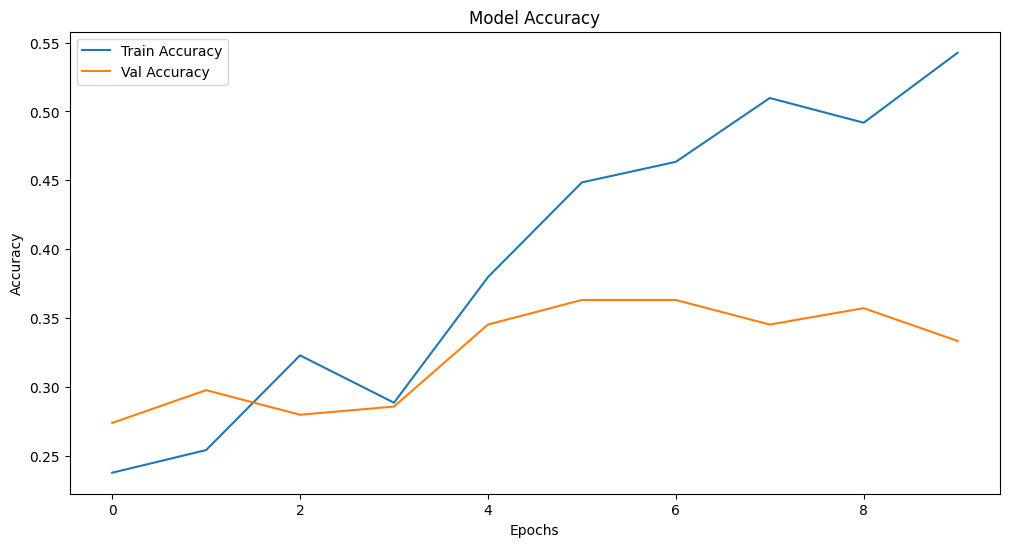

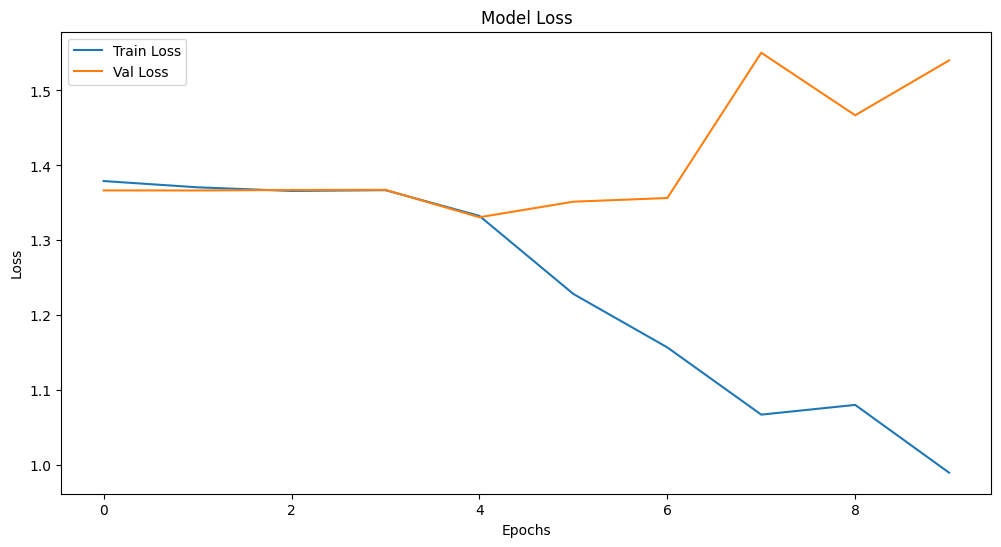

In [26]:
def evaluate_model(model, epochs=20, batch_size=32, silent=False):
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)
    if silent:
        return accuracy
    print(f'Test Accuracy: {accuracy:.2f}')

    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    return accuracy

lstm_accuracy = evaluate_model(lstm_model, epochs=10)

**Bidirectional LSTM Model Architecture**:

- Embedding Layer: Converts text input into dense vectors of fixed size.
- Spatial Dropout Layer: Adds spatial dropout to the embeddings to regularize and prevent overfitting.
- Bidirectional LSTM Layer: Processes the input sequence in both forward and backward directions, capturing context from both past and future.
- Dense Layer: Outputs the classification result.

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, SpatialDropout1D

def build_bi_lstm_model(dropout=0.2, units=100, output_dim=128):
    # Model architecture with Bidirectional LSTM
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length))
    model.add(SpatialDropout1D(dropout))
    model.add(Bidirectional(LSTM(units, dropout=dropout, recurrent_dropout=dropout)))
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

bi_lstm_model = build_bi_lstm_model()
bi_lstm_model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d_7             │ ?                      │   0 (unbuilt) │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.2466 - loss: 1.3763 - val_accuracy: 0.2976 - val_loss: 1.3613
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.4090 - loss: 1.3506 - val_accuracy: 0.3095 - val_loss: 1.3515
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.4067 - loss: 1.2952 - val_accuracy: 0.3631 - val_loss: 1.3118
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.5836 - loss: 1.0934 - val_accuracy: 0.3988 - val_loss: 1.3005
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.7660 - loss: 0.7515 - val_accuracy: 0.3690 - val_loss: 1.3698
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8599 - loss: 0.5095 - val_accuracy: 0.3988 - val_loss: 1.4844
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8918 - loss: 0.3630 - val_accuracy: 0.3988 - val_loss: 1.4874
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.9301 - loss: 0.2494 - val_accuracy: 0.3810 - 

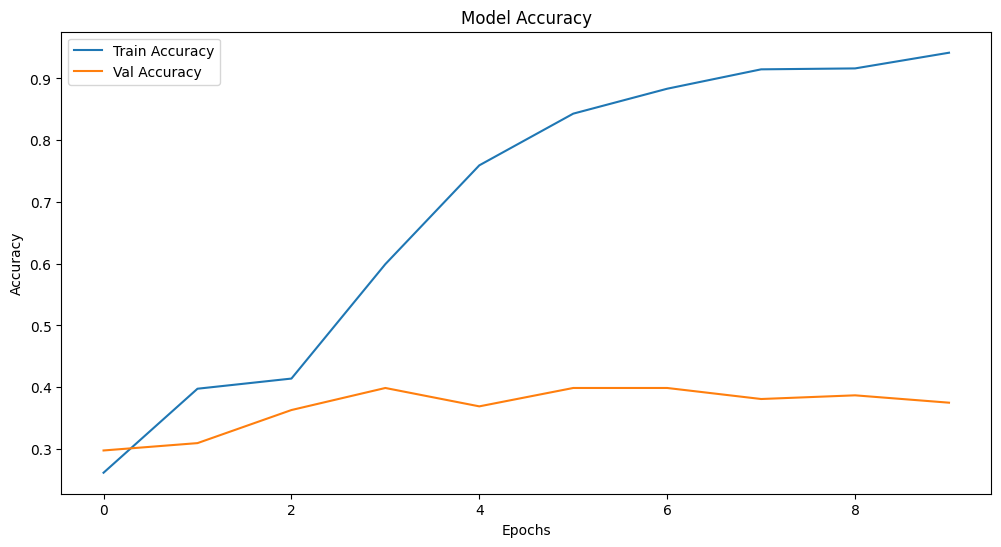

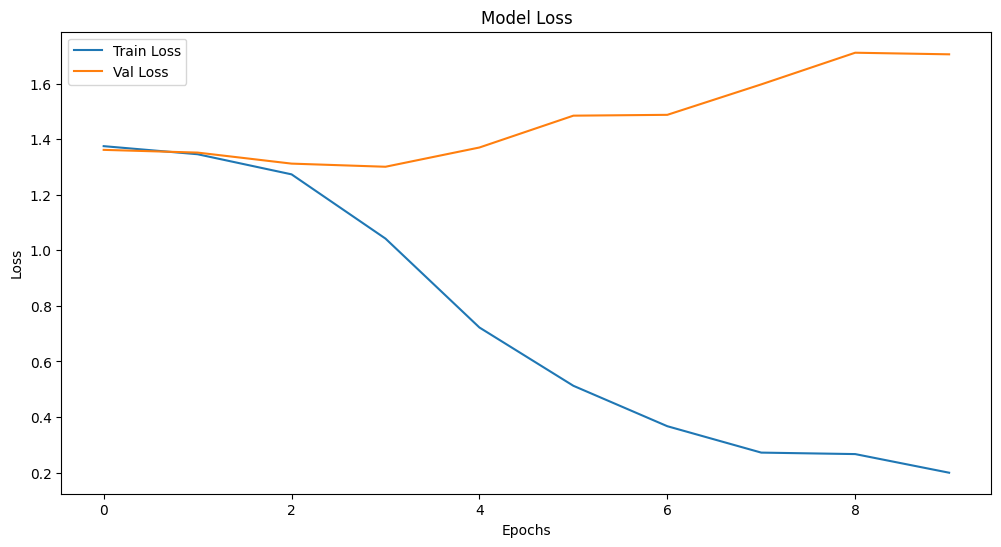

In [28]:
bi_lstm_accuracy = evaluate_model(bi_lstm_model, epochs=10)

### Hyperparameter tuning

There are several hyperparameters we can leverage to improve our model's performance. Let's try to use different dropout rate and epoch number to evaluate our model.

In [31]:
epochs = [10, 20]
dropouts = [0.2, 0.5]
results = []

for epoch in epochs:
    for dropout in dropouts:
        model = build_bi_lstm_model(dropout)
        accuracy = evaluate_model(model, epochs=epoch, silent=True)
        results.append((dropout, epoch, accuracy))

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.3161 - loss: 1.3735 - val_accuracy: 0.3810 - val_loss: 1.3649
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.3993 - loss: 1.3561 - val_accuracy: 0.3393 - val_loss: 1.3503
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.5585 - loss: 1.2712 - val_accuracy: 0.3512 - val_loss: 1.3483
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.6244 - loss: 1.0591 - val_accuracy: 0.3869 - val_loss: 1.4363
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7758 - loss: 0.7281 - val_accuracy: 0.3750 - val_loss: 1.4556
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - accuracy: 0.8646 - loss: 0.4567 - val_accuracy: 0.3393 - val_loss: 1.5426
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9348 - loss: 0.3108 - val_accuracy: 0.3810 - val_loss: 1.7121
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.9335 - loss: 0.2412 - val_accuracy: 0.3750 - 

### Sumarry

We use different model architecture and hyperparameters above to predict poem genres. Here is the summary:

In [33]:
print(f'LSTM, dropout=0.2, epochs=10, accuracy={lstm_accuracy}')
for dropout,epochs,accuracy in results:
    print(f'BiLSTM, dropout={dropout}, epochs={epochs}, accuracy={accuracy}')

LSTM, dropout=0.2, epochs=10, accuracy=0.1666666716337204
BiLSTM, dropout=0.2, epochs=10, accuracy=0.35333332419395447
BiLSTM, dropout=0.5, epochs=10, accuracy=0.15333333611488342
BiLSTM, dropout=0.2, epochs=20, accuracy=0.273333340883255
BiLSTM, dropout=0.5, epochs=20, accuracy=0.2933333218097687


## Conslusion

After we tried LSTM and BiLSTM model and other hyperparameters, the best test accuracy we got is around 0.3. Because there are four genres in this project, imagine we build a baseline model that predic any poem to a fixed genre, the baseline model's accuracy is 0.25. Our best performs a little bit better than the baseline model.

Bidirectional LSTM tends to have better performance in this project, as it provides better performance due to its ability to leverage the full context of the sequence.

Future work could involve experimenting with more advanced architectures, additional preprocessing techniques and increase dataset size.